In [25]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import json
from bs4 import BeautifulSoup
import requests
from datetime import datetime, date, time, timedelta
import sched
import time as mod_time
from pandas.io.json import json_normalize
from sklearn import preprocessing
import scipy.optimize as sco
% matplotlib inline


In [125]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [26]:
url = "https://api.coinmarketcap.com/v1/ticker/"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
dic = json.loads(soup.prettify())

# create an empty DataFrame
df = pd.DataFrame(columns=["Ticker", "MarketCap"])
 
for i in range(len(dic)):
    df.loc[len(df)] = [dic[i]['symbol'], dic[i]['market_cap_usd']]
 
df.sort_values(by=['MarketCap'])
P = df.iloc[:400]
P.head()
tickers = P['Ticker'].tolist()
tickers.append('IOTA')

In [27]:
#https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=60&aggregate=3&e=CCCAGG,
fysm = 'BTC'
tsym = 'USD'
d = json.loads(requests.get('https://min-api.cryptocompare.com/data/histohour?fsym=%s&tsym=%s&limit=6000&aggregate=1' % (fysm ,tsym)).text)
json_normalize(d)
df_BTC = pd.DataFrame(d['Data'])
#df_BTC['time'] =  pd.to_datetime(df_BTC['time'],unit='s')
df_BTC.set_index('time', drop=False, inplace=True)
df_BTC['BTC'] = df_BTC['close']
df_BTC = df_BTC[['BTC', 'time']] 

#df['time'] =  pd.to_datetime(df['time'],unit='s')
adding = 68
count = 0

for fysm in tickers: 
    if fysm == 'BTC':
        adding += 1
        print adding
    else:
        try:
            d = json.loads(requests.get('https://min-api.cryptocompare.com/data/histohour?fsym=%s&tsym=%s&limit=6000&aggregate=1' % (fysm, 'USD')).text)
            json_normalize(d)
            df = pd.DataFrame(d['Data'])
            df.set_index('time', drop=True, inplace=True)
            df_BTC[fysm] = df['close']
        except:
            print fysm
            continue
    

df_BTC.head()
df_BTC['time'] =  pd.to_datetime(df_BTC['time'],unit='s')
df_BTC.set_index('time', drop=True, inplace=True)

69
MIOTA
GXS
ACT


In [124]:
df = df_BTC.loc[:, (df_BTC != 0).any(axis=0)]
df = df.pct_change(12)[12:]

df = df.loc[:,(df.applymap(lambda x: x < 10).all(axis=0) == True)]
df.corr().to_clipboard()

In [82]:
#list of stocks in portfolio
stocks = df.columns
 
#download daily price data for each of the stocks in the portfolio
#data = web.DataReader(stocks,data_source='yahoo',start='01/01/2010')['Adj Close']

In [83]:
 
#convert daily stock prices into daily returns
returns = df


In [84]:
#calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
#set number of runs of random portfolio weights
num_portfolios = 25000
 
#set up array to hold results
#We have increased the size of the array to hold the weight values for each stock
results = np.zeros((4+len(df.columns)-1,num_portfolios))
results

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [89]:


 


for i in xrange(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(len(df.columns)))
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
 
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 365 * 2
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(365 * 2)
 
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]



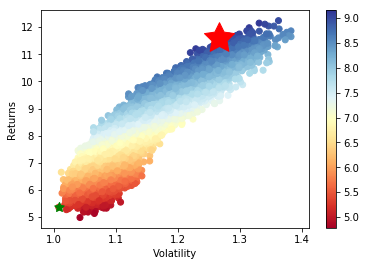

In [90]:
cols = ['ret','stdev','sharpe']
for i in stocks:
    cols.append(i)
cols
# convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns=[cols])
 
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
 
#create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=100)

In [122]:
round_weight = (1 / max_sharpe_port[3:].round(2).sum()) * max_sharpe_port[3:].round(2)

ValueError: No axis named 1920 for object type <class 'pandas.core.series.Series'>